In [1]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Lambda, Flatten, BatchNormalization, Dropout
from keras.models import Model
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.applications import EfficientNetB5
from keras.applications.efficientnet import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from keras.models import load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
from sklearn.metrics import classification_report, accuracy_score
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

C:\Users\Lenovo\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Lenovo\anaconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\Lenovo\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
import splitfolders


In [9]:
input_folder = 'C:/Users/Lenovo/Downloads/Augmented_dataset/Augmented__dataset'
#ration of split is 70%, 20% and 10%
splitfolders.ratio(input_folder, output="H:/Shortcuts/Research paper/flowerNET/New_flower", 
                   seed=42, ratio=(.7, .2, .1), 
                   group_prefix=None)

Copying files: 4342 files [02:18, 31.39 files/s]


In [3]:
# re-size all the images to this
IMAGE_SIZE = [600, 600]
BATCH_SIZE = 32

train_path = 'H:/Shortcuts/Research paper/flowerNET/New_flower/train'
valid_path = 'H:/Shortcuts/Research paper/flowerNET/New_flower/val'
test_path = 'H:/Shortcuts/Research paper/flowerNET/New_flower/test'

# useful for getting number of classes
folders = glob('H:/Shortcuts/Research paper/flowerNET/New_flower/train/*')
len(folders)

3

In [4]:
efficientNetB7 = EfficientNetB7(include_top=False, input_shape=IMAGE_SIZE + [3], weights="imagenet")

# Freeze the pretrained weights
efficientNetB7.trainable = False

# Rebuild top
x = GlobalAveragePooling2D(name="avg_pool")(efficientNetB7.output)
x = BatchNormalization()(x)

top_dropout_rate = 0.2
x = Dropout(top_dropout_rate, name="top_dropout")(x)
x = Dense(1024, activation='relu')(x)
prediction = Dense(3, activation="softmax", name="pred")(x)

# create a model object
model = Model(inputs=efficientNetB7.input, outputs=prediction)

# view the structure of the model
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 600, 600, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 600, 600, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 600, 600, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 601, 601, 3)  0           normalization[0][0]              
______________________________________________________________________________________________

block5c_se_reshape (Reshape)    (None, 1, 1, 1344)   0           block5c_se_squeeze[0][0]         
__________________________________________________________________________________________________
block5c_se_reduce (Conv2D)      (None, 1, 1, 56)     75320       block5c_se_reshape[0][0]         
__________________________________________________________________________________________________
block5c_se_expand (Conv2D)      (None, 1, 1, 1344)   76608       block5c_se_reduce[0][0]          
__________________________________________________________________________________________________
block5c_se_excite (Multiply)    (None, 38, 38, 1344) 0           block5c_activation[0][0]         
                                                                 block5c_se_expand[0][0]          
__________________________________________________________________________________________________
block5c_project_conv (Conv2D)   (None, 38, 38, 224)  301056      block5c_se_excite[0][0]          
__________

Total params: 66,733,466
Trainable params: 2,630,659
Non-trainable params: 64,102,807
__________________________________________________________________________________________________


In [5]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)


In [6]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=0,
                                   vertical_flip=False,
                                   horizontal_flip = True)

val_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (600, 600),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

val_set = val_datagen.flow_from_directory(valid_path,
                                            target_size = (600, 600),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 3037 images belonging to 3 classes.
Found 867 images belonging to 3 classes.


In [ ]:
r = model.fit(
  training_set,
  validation_data=val_set,
  epochs=35,
  steps_per_epoch=len(training_set),
  validation_steps=len(val_set)
)

Epoch 1/35
95/95 [==============================] - ETA: 0s - loss: 2.8566 - accuracy: 0.3309  

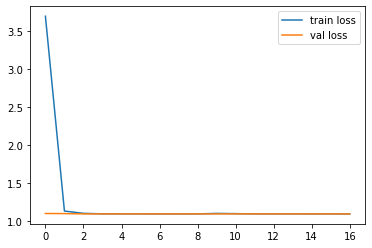

In [7]:
# loss

plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()

plt.savefig('H:/Shortcuts/Research paper/flowerNET/35-epoch/EfficientNetB0/LossVal_loss_EfficientNetB0.svg')
plt.savefig('H:/Shortcuts/Research paper/flowerNET/35-epoch/EfficientNetB0/LossVal_loss_EfficientNetB0')
plt.show()

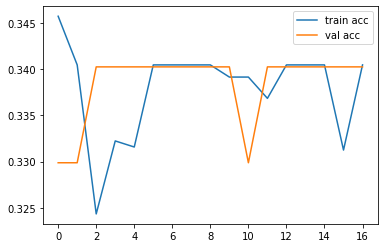

In [8]:
#plotting val acc and training acc

plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()

plt.savefig('H:/Shortcuts/Research paper/flowerNET/35-epoch/EfficientNetB0/accuracy_EfficientNetB0.svg')
plt.savefig('H:/Shortcuts/Research paper/flowerNET/35-epoch/EfficientNetB0/accuracy_EfficientNetB0')
plt.show()

In [9]:
model.save('H:/Shortcuts/Research paper/flowerNET/35-epoch/EfficientNetB0/EfficientNetB0.h5')

C:\Users\Lenovo\anaconda3\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [10]:
train_loss, train_acc = model.evaluate(training_set, steps=16)
val_loss, val_acc = model.evaluate(val_set, steps=16)
print("Traning Loss and traing accurcy: ",train_loss, train_acc )
print("Validation Loss and Validation accurcy: ",val_loss, val_acc )

16/16 [==============================] - 30s 2s/step - loss: 1.0984 - accuracy: 0.3457
Traning Loss and traing accurcy:  1.0987430810928345 0.33203125
Validation Loss and Validation accurcy:  1.0984094142913818 0.345703125


In [11]:
testing_set = tf.keras.preprocessing.image_dataset_from_directory(
    test_path,
    seed=123,
    shuffle=False,
    image_size=(224,224),
    batch_size=BATCH_SIZE
)

Found 438 files belonging to 3 classes.


In [12]:
class_names = testing_set.class_names
class_names

['Black_Spot', 'Downy_mildew', 'Fresh_Leaf']

In [13]:
# Extracting all test image and corrosponding labels from tesing image
test_label=[]
test_img=[]
for img, label in testing_set:
  #print(label.numpy())
  test_label.append(label.numpy())
  test_img.append(img.numpy())
print("Total batch of test label: ",len(test_label))
print("Total batch of test image: ",len(test_img))

###############################################################################################

# Extracting only all test image  from tesing image batch list
actual_img=[]
for i in range(len(test_img)):
  for i in test_img[i]:
    i = i*(1/255) # we have to rescale the test image as well to feed the model
    actual_img.append(i)

print("Total Number of image: ", len(actual_img))


# Extracting only all test image  labels from tesing image batch list
actual_label=[]
for i in range(len(test_label)):
  for i in test_label[i]:
    actual_label.append(class_names[i])
     
    

print("Total number of image label : ",len(actual_label))

Total batch of test label:  14
Total batch of test image:  14
Total Number of image:  438
Total number of image label :  438


Black_Spot


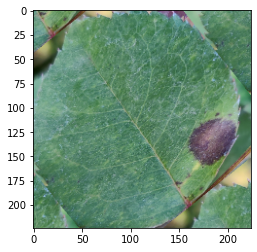

In [14]:
print(actual_label[27])
plt.imshow(actual_img[27])

In [15]:
# make prediction using loaded model
predicted_label=[]
for img in actual_img:
  img_array = tf.expand_dims(img, 0)
  predictions = model.predict(img_array)
  label= class_names[np.argmax(predictions)]
  
  predicted_label.append(label)
 
  

len(predicted_label)

438

In [16]:
# Printing all evaluation matrix
print("Test accuracy: ",accuracy_score(actual_label, predicted_label))
print(classification_report(actual_label, predicted_label))

Test accuracy:  0.3401826484018265
              precision    recall  f1-score   support

  Black_Spot       0.00      0.00      0.00       145
Downy_mildew       0.34      1.00      0.51       149
  Fresh_Leaf       0.00      0.00      0.00       144

    accuracy                           0.34       438
   macro avg       0.11      0.33      0.17       438
weighted avg       0.12      0.34      0.17       438



C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


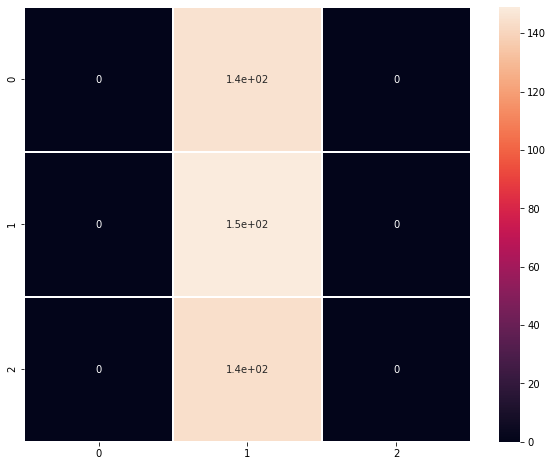

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(actual_label, predicted_label)
import seaborn as sns
ax= plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, linewidth=.5)
plt.plot()
plt.savefig("H:/Shortcuts/Research paper/flowerNET/35-epoch/EfficientNetB0/confussion_matrix_EfficientNetB0.svg")
plt.savefig("H:/Shortcuts/Research paper/flowerNET/35-epoch/EfficientNetB0/confussion_matrix_EfficientNetB0")
plt.show()